# Multivariate Gaussian Mixture Model
The multivariate Gaussian Mixture Model can be represented as:
$$
\begin{align*}
    p(\mathbf{s})   &= \mathrm{Dir}(\mathbf{s}|\boldsymbol{\alpha}) \\
    p(\mathbf{m}_{l}) &=  \mathcal{N}(m_l|\boldsymbol{\mu}_l, \boldsymbol{\Sigma}_l) \\    
    p(\mathbf{W}_{l}) &=  \mathcal{W}(\mathbf{W}_l|\mathbf{V}_l, \nu_l) \\
    p(\mathbf{z}_i) &=  \mathrm{Cat}(\mathbf{z}_i|\mathbf{s}) \\
    p(\mathbf{y}_i) &= \prod_{l=1}^L \mathcal{N}\left(\mathbf{m}_{l}, \mathbf{W}_{l}\right)^{\mathbf{z}_{i}}
\end{align*}
$$

In [1]:
ENV["GKS_ENCODING"]="utf8"

using Rocket, ReactiveMP, GraphPPL
using Distributions, Plots
using Random, LinearAlgebra, BenchmarkTools

In [2]:
Random.seed!(125)

L         = 50.0
nmixtures = 6
n_samples = 500

probvec = ones(nmixtures)
probvec = probvec ./ sum(probvec)

switch = Categorical(probvec)

println("Switch distribution: ", Distributions.params(switch))

gaussians = map(1:nmixtures) do index
    angle      = 2π / nmixtures * (index - 1)
    basis_v    = L * [ 1.0, 0.0 ]
    rotationm  = [ cos(angle) -sin(angle); sin(angle) cos(angle) ]
    mean       = rotationm * basis_v 
    covariance = Matrix(Hermitian(rotationm * [ 10.0 0.0; 0.0 20.0 ] * transpose(rotationm)))
    return MvNormal(mean, covariance)
end

z = rand(switch, n_samples)
y = Vector{Vector{Float64}}(undef, n_samples)

for i in 1:n_samples
    y[i] = rand(gaussians[z[i]])
end

Switch distribution: ([0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666],)


In [3]:
sdim(n) = (a) -> map(d -> d[n], a)

sdim (generic function with 1 method)

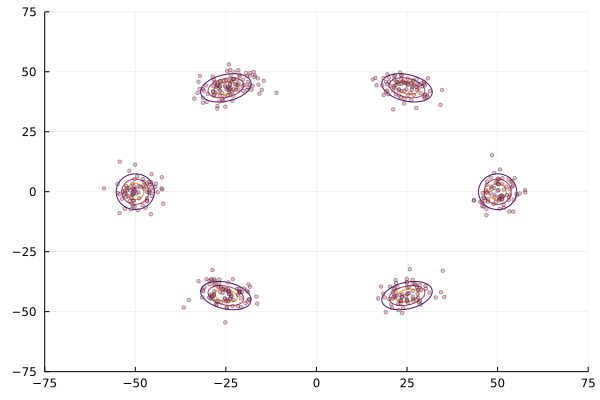

In [71]:
p = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

for (index, gaussian) in enumerate(gaussians)
    p = contour!(p, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), levels = 3, colorbar = false)
end

p = scatter!(y |> sdim(1), y |> sdim(2), ms = 2, alpha = 0.4)

plot(p, size = (600, 400), legend=false)

In [47]:
@model function gaussian_mixture_model(rng, nmixtures, n, priors_mean, priors_cov)
    
    z = randomvar(n)
    m = randomvar(nmixtures)
    w = randomvar(nmixtures)
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures        
        m[i] ~ MvNormalMeanCovariance(priors_mean[i], priors_cov[i])
        w[i] ~ Wishart(3, [ 1e2 0.0; 0.0 1e2 ])
    end
    
    s ~ Dirichlet(ones(nmixtures))

    y = datavar(Vector{Float64}, n)
    
    means = tuple(m...)
    precs = tuple(w...)
    
    for i in 1:n
        z[i] ~ Categorical(s) where { q = MeanField() }
        y[i] ~ NormalMixture(z[i], means, precs) where { q = MeanField() }
    end
    
    return s, z, m, w, y
end

In [57]:
function inference_(rng, nmixtures, data, viters)
    n = length(data)
    
    model, (s, z, m, w, y) = gaussian_mixture_model(rng, nmixtures, n)
    
    means_estimates  = keep(Vector{Marginal})
    precs_estimates  = keep(Vector{Marginal})
    switch_estimates = keep(Marginal)
    fe_values        = keep(Float64)

    s_sub = subscribe!(getmarginal(s), switch_estimates)
    m_sub = subscribe!(getmarginals(m), means_estimates)
    p_sub = subscribe!(getmarginals(w), precs_estimates)
    f_sub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe_values)
    
    setmarginal!(s, vague(Dirichlet, nmixtures))
    
    basis_v = [ 1.0, 0.0 ]
    
    for i in 1:nmixtures
        # Assume we now only approximate location of cluters's mean
        approximate_angle_prior = ((2π + + rand(rng)) / nmixtures) * (i - 1)
        approximate_basis_v  = L / 2 * (basis_v .+ rand(rng, 2))
        approximate_rotation = [ cos(approximate_angle_prior) -sin(approximate_angle_prior); sin(approximate_angle_prior) cos(approximate_angle_prior) ]
        mean_mean_prior     = approximate_rotation * approximate_basis_v
        mean_mean_cov       = [ 1e6 0.0; 0.0 1e6 ]
        
        setmarginal!(m[i], MvNormalMeanCovariance(mean_mean_prior, mean_mean_cov))
        setmarginal!(w[i], Wishart(3, [ 1e2 0.0; 0.0 1e2 ]))
    end
    
    for i in 1:viters
        update!(y, data)
    end
    
    unsubscribe!((s_sub, m_sub, p_sub, f_sub))
    
    return switch_estimates, means_estimates, precs_estimates, fe_values
end

inference_ (generic function with 1 method)

In [64]:
rng = MersenneTwister(11)

# Assume we now only approximate location of cluters's mean
basis_v = [ 1.0, 0.0 ]
priors_mean = []
for i in 1:nmixtures
    approximate_angle_prior = ((2π + + rand(rng)) / nmixtures) * (i - 1)
    approximate_basis_v  = L / 2 * (basis_v .+ rand(rng, 2))
    approximate_rotation = [ cos(approximate_angle_prior) -sin(approximate_angle_prior); sin(approximate_angle_prior) cos(approximate_angle_prior) ]
    push!(priors_mean,  approximate_rotation * approximate_basis_v)
end

priors_cov = [[ 1e6 0.0; 0.0 1e6 ] for _ in 1:nmixtures]

model = Model(gaussian_mixture_model, rng, nmixtures, length(y), priors_mean, priors_cov)
data = (y = y,)

initmarginals = (s = vague(Dirichlet, nmixtures), m = [MvNormalMeanCovariance(x[1], x[2]) for x in zip(priors_mean, priors_cov)], w = Wishart(3, [ 1e2 0.0; 0.0 1e2 ]))

@time result = inference(model=model, data=data, initmarginals=initmarginals, iterations=25, free_energy=true);

  0.941145 seconds (6.84 M allocations: 670.606 MiB, 20.87% gc time)


In [75]:
using Parameters
@unpack s, z, m, w = result.posteriors
fe = result.free_energy;

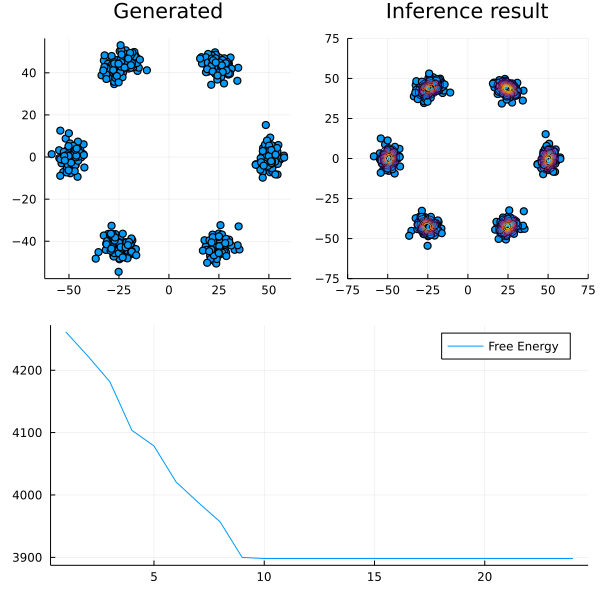

In [74]:
pe = plot(xlim = (-1.5L, 1.5L), ylim = (-1.5L, 1.5L))

rp = scatter(y |> sdim(1), y |> sdim(2), legend=false, title="Generated")

pe = scatter!(pe, y |> sdim(1), y |> sdim(2))

e_means = mean.(m[end])
e_precs = mean.(w[end])

for (e_m, e_w) in zip(e_means, e_precs)
    gaussian = MvNormal(e_m, Matrix(Hermitian(inv(e_w))))
    pe = contour!(pe, range(-2L, 2L, step = 0.25), range(-2L, 2L, step = 0.25), (x, y) -> pdf(gaussian, [ x, y ]), title="Inference result", legend=false, levels = 7, colorbar = false)
end

pfe = plot(fe[2:end], label = "Free Energy")

plot(rp, pe, pfe, size = (600, 600), layout = @layout([ a b; c ]))

In [77]:
@benchmark inference(model=$model, data=$data, initmarginals=$initmarginals, iterations=25, free_energy=true)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  885.197 ms … 984.972 ms  ┊ GC (min … max):  9.26% … 17.01%
 Time  (median):     937.348 ms               ┊ GC (median):    16.86%
 Time  (mean ± σ):   933.914 ms ±  32.787 ms  ┊ GC (mean ± σ):  15.75% ±  3.17%

  ▁                  ▁           █  ▁                         ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  885 ms           Histogram: frequency by time          985 ms <

 Memory estimate: 670.61 MiB, allocs estimate: 6836557.